Imports

In [1]:
import torch
from datetime import datetime
from training import EarlyStopping
import preprocessing_data_new
import numpy as np
from sklearn.model_selection import train_test_split
import preprocessing_graph_new
import config

Preprocessing

In [2]:
num_classes  = 2
target_column = 'ddg'
rel_pred = True
cbs_df, num_cond = preprocessing_data_new.preprocess_cbs(data_path='CBS_10-04-2023.csv',
                                                         n_classes = num_classes,
							                            target_column = target_column, aug_data = False, threshs=[56],
                                                         dropping_list=None, merge_columns=False,
                                                         verbose=True)
print(cbs_df['ee'].mean())
cbs_df['label2'] = cbs_df['ee'].apply(lambda x: np.array([0.0, 1.0]) if x<= cbs_df['ee'].mean() else np.array([1.0, 0.0]))
cbs_df['label2'] = cbs_df['label2'].apply(lambda x: [float(i) for i in x])
if rel_pred:
    # if AC column is S, then -x
    # if AC column is R, then +x
    cbs_df['ddg'] = cbs_df.apply(lambda x: x['ddg'] if x['AC'] == 'S' else -x['ddg'], axis=1)
    # same for ee
    cbs_df['ee'] = cbs_df.apply(lambda x: x['ee'] if x['AC'] == 'S' else -x['ee'], axis=1)

train_data, val_data = train_test_split(cbs_df, test_size=0.2, random_state=1337, stratify=cbs_df['label2'])

Length of initial dataframe: 100
Inital Mean ee: 57.15
Inital Median ee: 65.0
Index(['r1', 'p', 'cat', 'T', 'n', 'AC', 't', 'y', 'ee', 'er', 'exp_ee', 'ddg',
       'class0', 'class1', 'borane_BH3.DMS', 'solv_THF'],
      dtype='object')
57.15


Graph Preprocessing

In [3]:
best_parameters =  config.best_parameters

bs_val = len(val_data)
val_data = val_data.reset_index()
train_data = train_data.reset_index()
train_gloader, train_dloader, train_graph_list = preprocessing_graph_new.my_graph_only_dataloader(train_data,
                                                                                   target_column=target_column,
                                                                                    bs=best_parameters['bs'])
val_gloader, val_dloader, val_graph_list = preprocessing_graph_new.my_graph_only_dataloader(val_data,
                                                                               target_column=target_column,
                                                                               bs=bs_val)


# ddg to ee function

In [4]:
def calc_ee(ddg, T):
    '''
    ddG in kcal/mol
    er = exp(-ddg/RT) = (1 + ee)/(1 - ee)
    X = exp(-ddg/RT)
    X = (1 + ee)/(1 - ee)
    
    -> ee = (X - 1)/(1 + x)
    
    '''

    ddg *= 4.1839954  # kJ / mol
    T = float(T) + 273.15 # K
    R_const = 8.31446261815324/1000 # kJ / (mol K)
    X = np.exp(ddg/(R_const*T))
    ee = (X - 1)/(1 + X)

    return ee

In [6]:
from models import Net
loss_fn = torch.nn.MSELoss()
now = datetime.now()
time_str = now.strftime("%d_%m_%Y_%H_%M")
#device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
early_stopping = EarlyStopping(patience=200,
                               verbose=True,
                               path=f"Net{time_str}.pt",
                               delta=0.0001)

cbs_model = Net(gnn_dim=best_parameters['embedding_size'],
                n_gnn_layers=best_parameters['n_gnn_layers'],
                n_ffnn_neurons=best_parameters['hl_size'],
                n_ffnn_layers=best_parameters['n_hl'],
                pool_type=best_parameters['pooling'],
                activation_function=best_parameters['activation']
                ).to(device)
training = True
if training:
    optimizer = torch.optim.Adam(cbs_model.parameters(), lr=best_parameters['lr'])

    def train(model, graph_loader, optimizer, epoch, loss_fn):
        model.train()
        loss_all = 0
        # Enumerate over the data
        for data_graph in graph_loader:
            # Use GPU
            data_graph.to(device)
            # Reset gradients
            optimizer.zero_grad()
            # Passing the node features and the connection info
            mu = model(data_graph.x, data_graph.edge_index, data_graph.batch, data_graph.edge_attr)

            # Calculating the loss and gradients
            loss = loss_fn(mu, data_graph.ee)  
            loss_all += loss.item() 
            loss.backward()
            # Update using the gradients
            optimizer.step()


        return loss_all / len(graph_loader)

    def val(model, graph_loader, loss_fn):
        loss_all = 0
        model.eval()
        for data_graph_val in graph_loader:
            with torch.no_grad():
                data_graph_val.to(device)
                mu = model(data_graph_val.x, data_graph_val.edge_index, data_graph_val.batch, data_graph_val.edge_attr)

                # Calculating the loss and gradients
                loss = loss_fn(mu, data_graph_val.ee)  
                loss_all += loss.item() 

        return loss_all / len(graph_loader)

    best_epoch = 0
    best_loss = 10000
    best_acc = 0

    print("Starting training...")

    losses = []
    val_losses = []
    accs = []
    val_accs = []

    for epoch in range(2000):
        loss = train(cbs_model, train_gloader, optimizer, epoch, loss_fn)
        val_loss = val(cbs_model, val_gloader, loss_fn)

        losses.append(loss)
        val_losses.append(val_loss)

        #scheduler.step(val_loss)
        if epoch % 1 == 0:
            print(f"Epoch {epoch} | Train Loss {loss:.4f} | Val Loss {val_loss:.4f}")

        early_stopping(val_loss, cbs_model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
    cbs_model.load_state_dict(torch.load(f"Net{time_str}.pt"))
else:
    cbs_model.load_state_dict(torch.load(f"Trained_Models/Net_xxx.pt"))

Starting training...
Epoch 0 | Train Loss 1.2967 | Val Loss 0.9625
Validation loss decreased (inf --> 0.962519).  Saving model ...
Epoch 1 | Train Loss 0.9305 | Val Loss 1.0844
EarlyStopping counter: 1 out of 200
Epoch 2 | Train Loss 0.9670 | Val Loss 1.2968
EarlyStopping counter: 2 out of 200
Epoch 3 | Train Loss 0.9335 | Val Loss 1.3080
EarlyStopping counter: 3 out of 200
Epoch 4 | Train Loss 0.9495 | Val Loss 1.2627
EarlyStopping counter: 4 out of 200
Epoch 5 | Train Loss 0.8873 | Val Loss 1.0945
EarlyStopping counter: 5 out of 200
Epoch 6 | Train Loss 0.8436 | Val Loss 1.0740
EarlyStopping counter: 6 out of 200
Epoch 7 | Train Loss 0.8217 | Val Loss 1.0545
EarlyStopping counter: 7 out of 200
Epoch 8 | Train Loss 0.8754 | Val Loss 1.1178
EarlyStopping counter: 8 out of 200
Epoch 9 | Train Loss 0.8916 | Val Loss 0.9309
Validation loss decreased (0.962519 --> 0.930902).  Saving model ...
Epoch 10 | Train Loss 0.7708 | Val Loss 1.0326
EarlyStopping counter: 1 out of 200
Epoch 11 | Trai

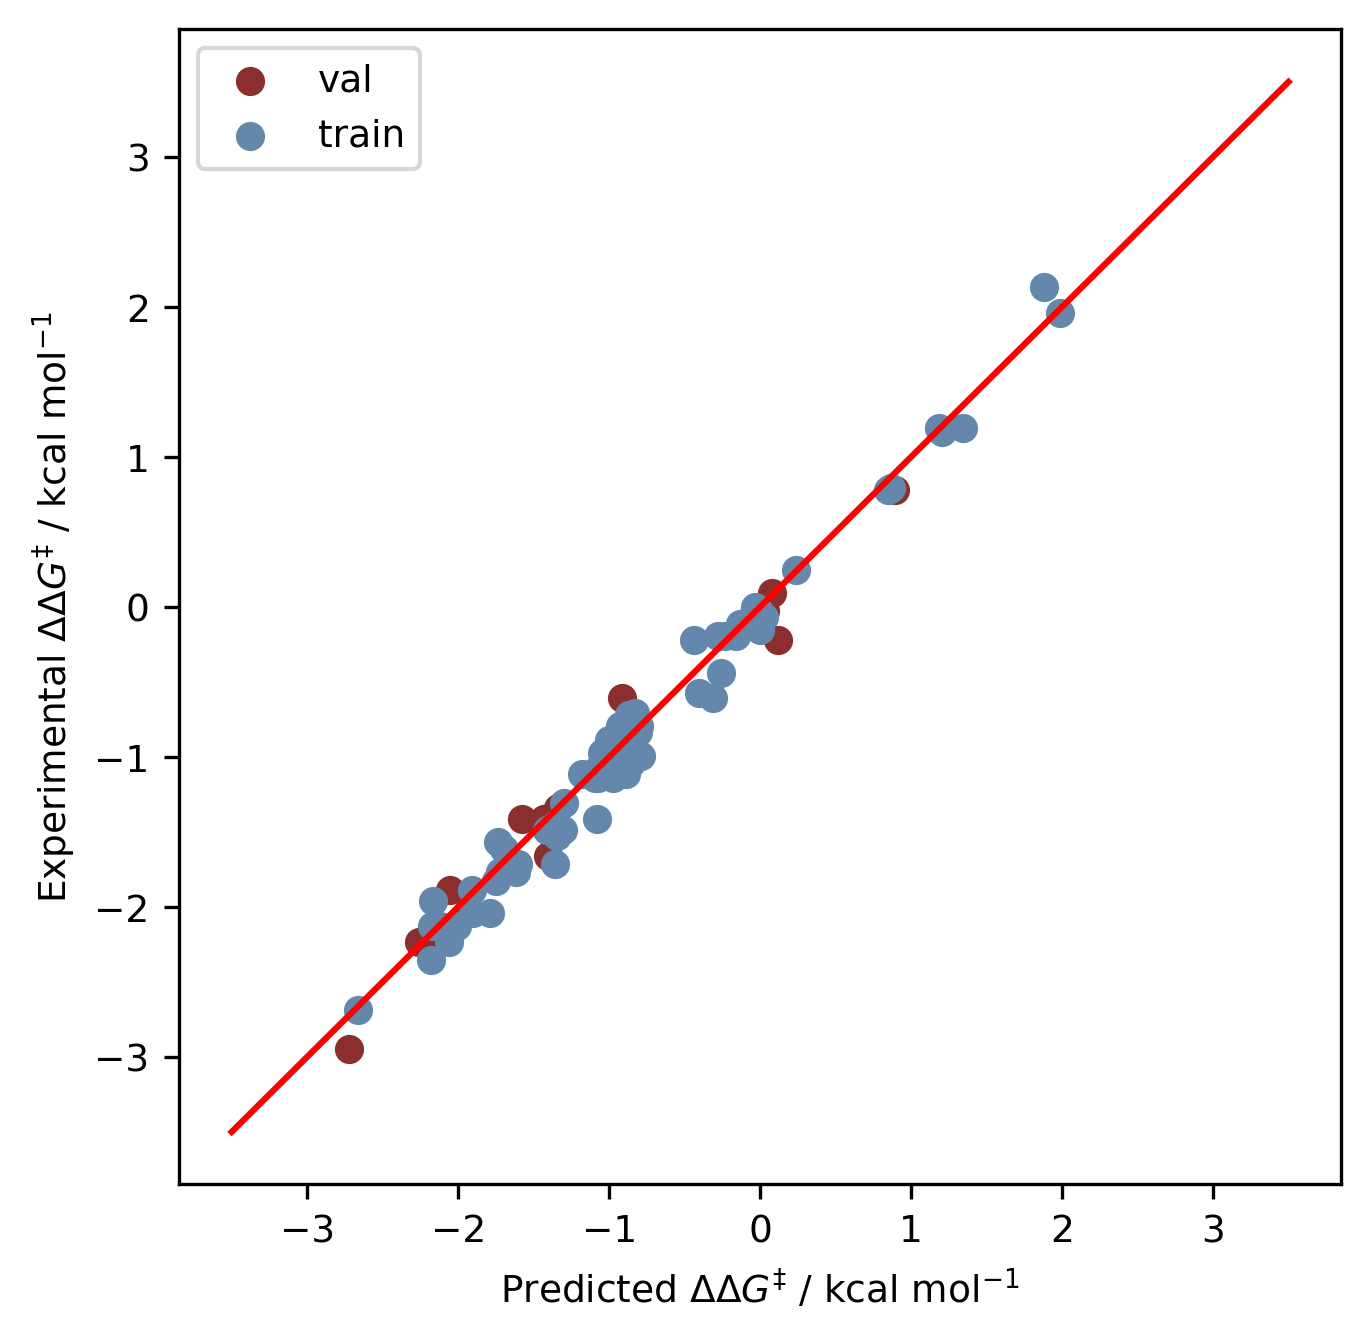

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5), dpi=300)
# reset mpl parameters
plt.rcParams.update(plt.rcParamsDefault)
# set font size to 9
plt.rcParams.update({'font.size': 9})
# also ticks
plt.rc('xtick', labelsize=9)

cbs_model.eval()
predictions_train = []
real_train = []
for val_graph in train_gloader:
    with torch.no_grad():
        val_graph.to(device)

        mu = cbs_model(val_graph.x, val_graph.edge_index, val_graph.batch, val_graph.edge_attr) 
        dataf = pd.DataFrame()
        dataf["y_real"] = val_graph.ee.tolist()
        dataf["y_pred"] = mu.tolist()
    
    for pred_list in dataf["y_pred"].values.tolist():
        predictions_train.append(pred_list[0])

    for real_list in dataf["y_real"].values.tolist():
        real_train.append(real_list[0])

for val_graph in val_gloader:
    with torch.no_grad():
        val_graph.to(device)

        mu = cbs_model(val_graph.x, val_graph.edge_index, val_graph.batch, val_graph.edge_attr) 
        dataf = pd.DataFrame()
        dataf["y_real"] = val_graph.ee.tolist()
        dataf["y_pred"] = mu.tolist()
    predictions = []
    for pred_list in dataf["y_pred"].values.tolist():
        predictions.append(pred_list[0])
    real = []
    for real_list in dataf["y_real"].values.tolist():
        real.append(real_list[0])
        
max_vals = [np.max(predictions),  np.max(predictions_train),
                  np.max(real),  np.max(real_train)]
max_val = np.max(max_vals)

df_predictions_train = pd.DataFrame({
    'Pred': predictions_train,
    'Real': real_train
})

df_predictions_val = pd.DataFrame({
    'Pred': predictions,
    'Real': real
})

#df_predictions_train.to_csv(f'preds_train{time_str}.csv')
#df_predictions_val.to_csv(f'preds_val{time_str}.csv')

plt.scatter(predictions, real, color='#8B2E2E', label='val')
plt.scatter(predictions_train, real_train, color='#6388AC', label='train')
plt.plot([-3.5,3.5],[-3.5,3.5],'r')
#plt.xlim(0, 3.5)
#plt.ylim(0, 3.5)
plt.xlabel('Predicted $\Delta\Delta G^‡$ / kcal mol$^{-1}$', fontsize=9)
plt.ylabel('Experimental $\Delta\Delta G^‡$ / kcal mol$^{-1}$', fontsize=9)
plt.legend()
plt.savefig(f'Performance_Net.png', dpi=300)
plt.show()



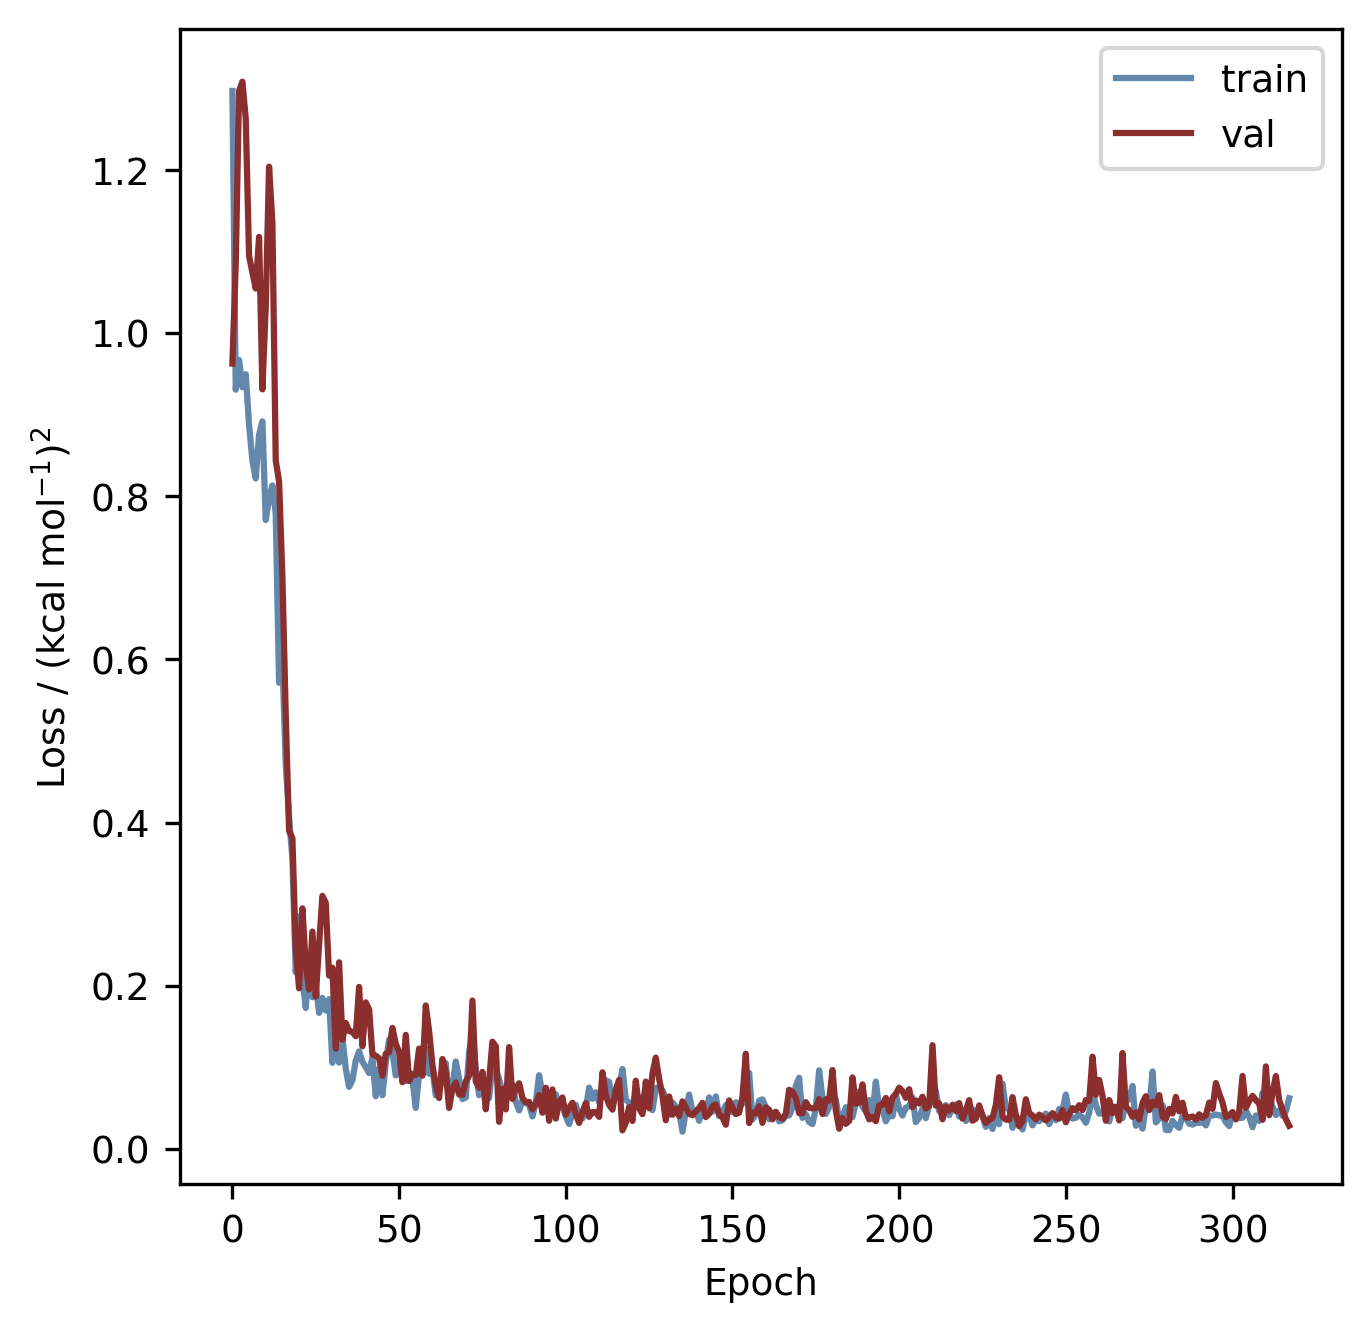

In [10]:
# plot learning curves
plt.figure(figsize=(5,5), dpi=300)
plt.plot(losses, label='train', color='#6388AC')
plt.plot(val_losses, label='val', color='#8B2E2E')
plt.xlabel('Epoch')
plt.ylabel('Loss / (kcal mol$^{-1}$)$^2$')
plt.legend()
plt.savefig(f'Net_loss.png', dpi=300)

# Predictions

Length of initial dataframe: 42
Inital Mean ee: 69.0
Inital Median ee: 69.0
Index(['Unnamed: 0', 'r1', 'p', 'cat', 'T', 'ee', 'exp_ee', 'ddg', 'class0',
       'class1', 'borane_BH3.DMS', 'solv_THF'],
      dtype='object')
ddG   --   ee   -- cat     
-0.54 -- -39.7 -- [H]B1OC(C2=CC(OC)=CC(OC)=C2)(C3=CC(OC)=CC(OC)=C3)[C@H]4N1CCC4 -- CC(CC)=O
-0.85 -- -58.1 -- [H]B1OC(C2=CC(C)=CC(OC)=C2)(C3=CC(OC)=CC(C)=C3)[C@H]4N1CCC4 -- CC(CC)=O
-0.88 -- -59.4 -- [H]B1OC(C2=CC=C(OC)C(C)=C2)(C3=CC(C)=C(OC)C=C3)[C@H]4N1CCC4 -- CC(CC)=O
-0.92 -- -61.5 -- [H]B1OC(C2=CC(OC)=C(OC)C(OC)=C2)(C3=CC(OC)=C(OC)C(OC)=C3)[C@H]4N1CCC4 -- CC(CC)=O
-1.02 -- -66.0 -- [H]B1OC(C2=CC=C(C)C(OC)=C2)(C3=CC(OC)=C(C)C=C3)[C@H]4N1CCC4 -- CC(CC)=O
-1.06 -- -67.6 -- [H]B1OC(C2=CC=C(N(CC)CC)C=C2)(C3=CC=C(N(CC)CC)C=C3)[C@H]4N1CCC4 -- CC(CC)=O
-1.08 -- -68.4 -- [H]B1OC(C2=CC=CC(C3=CC=CC=C3)=C2)(C4=CC(C5=CC=CC=C5)=CC=C4)[C@H]6N1CCC6 -- CC(CC)=O
-1.10 -- -69.2 -- [H]B1OC(C2=CC=C(C(C)C)C=C2)(C3=CC=C(C(C)C)C=C3)[C@H]4N1CCC4 -- CC(CC)=O
-

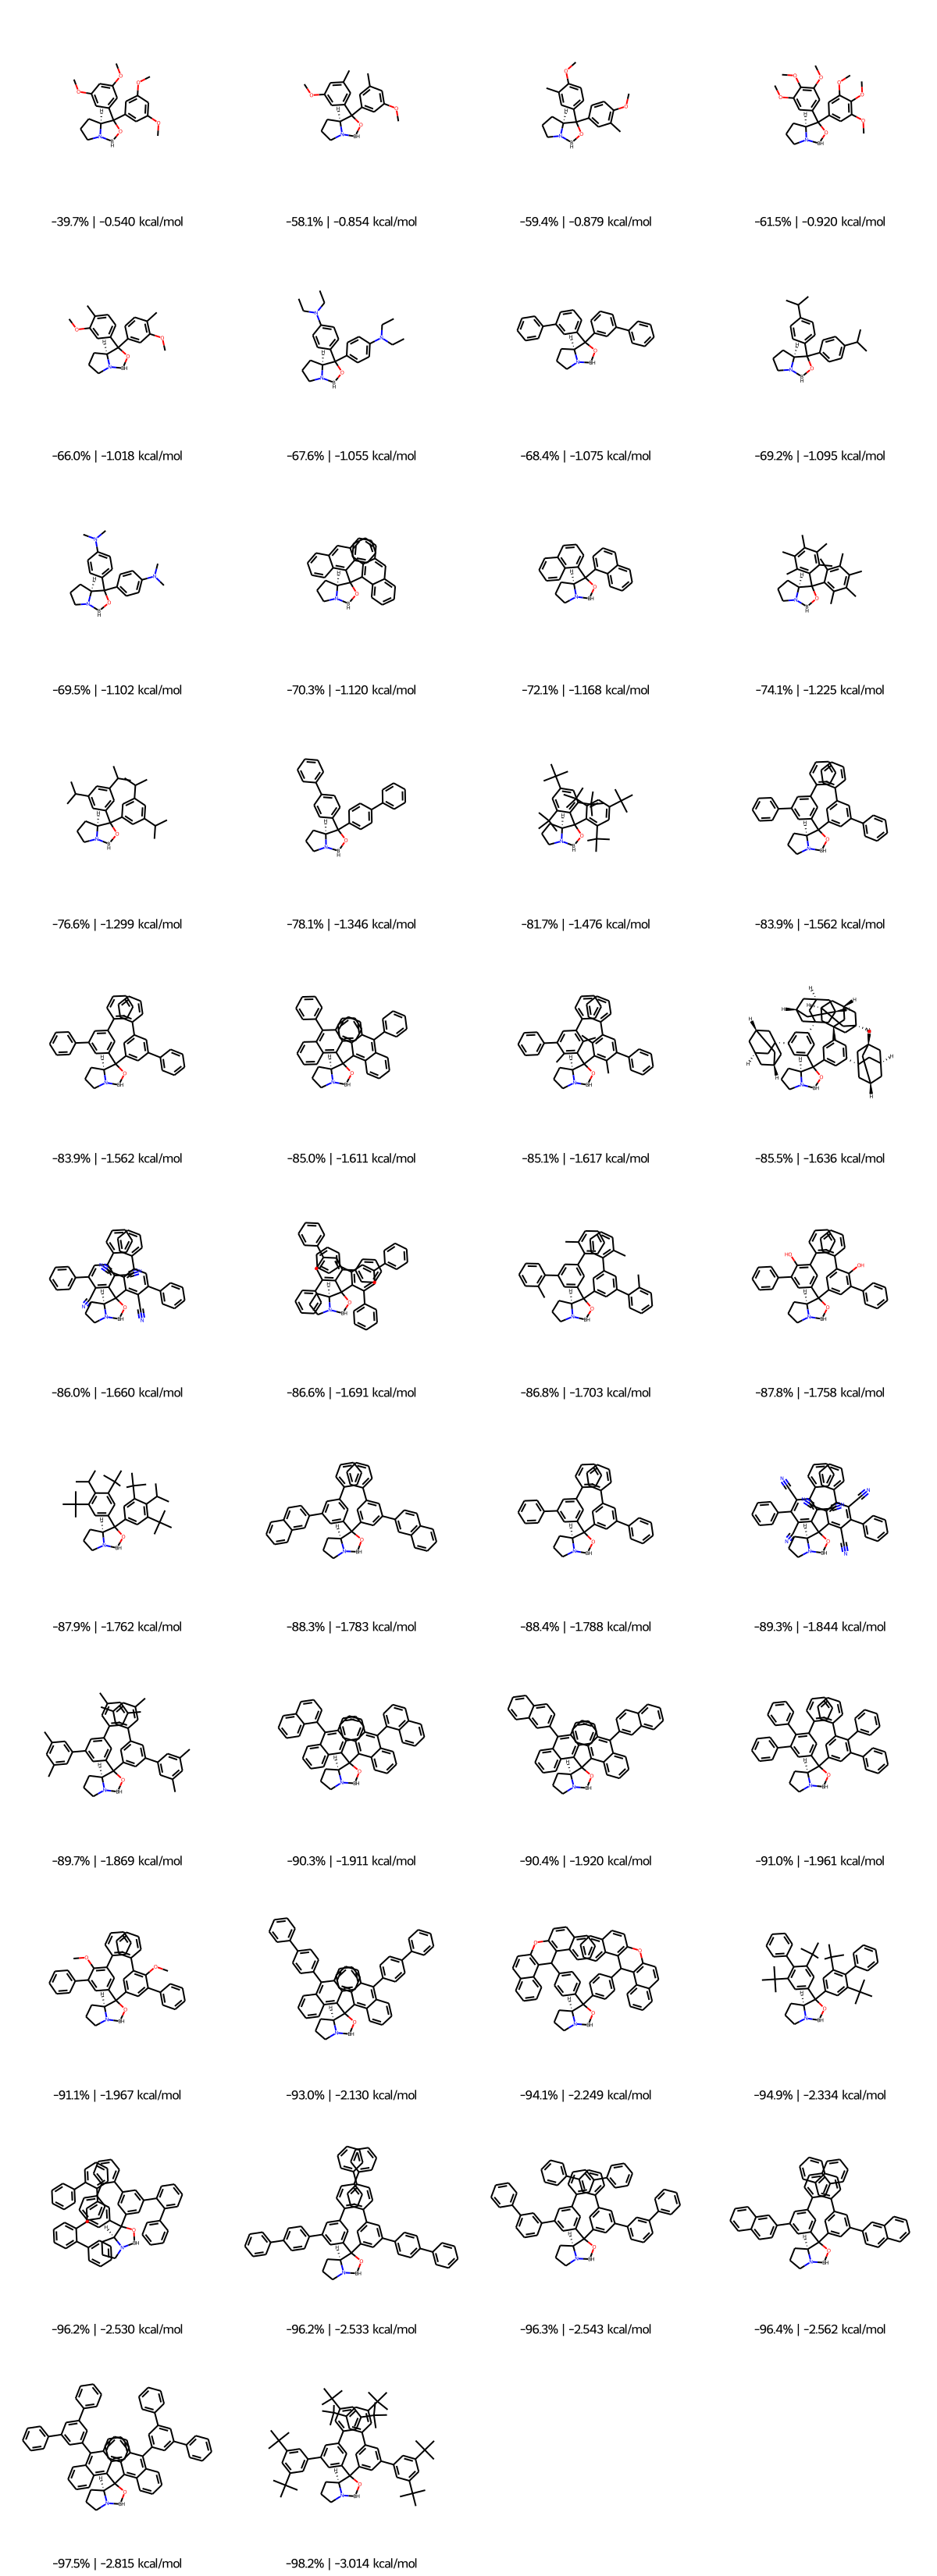

In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

screening_method = 'cats'

if screening_method == 'subs':

    cat = '[H]B1OC([C@H]2N1CCC2)(C3=CC(C(C)(C)C)=CC(C(C)(C)C)=C3)C4=CC(C(C)(C)C)=CC(C(C)(C)C)=C4'

    subs = ['O=C(C)C1=CC=CC=C1',
            'O=C(C1=CC=CC=C1)C(OC)=O',
            'CC(CC)=O',
            'O=C(CC)CCC',
            'CC(CCl)=O',
            'O=C(C)C(C)C',
            'CC(CCC)=O',
            'CC(C1CCCCC1)=O',
            'CC(C(C)(C)C)=O',
            'O=C(CCCCC)C',      
            ]
# some cats might be duplicates
elif screening_method == 'cats':
    cats = [
        '[H]B1OC(C2=CC(C3=CC=CC=C3)=CC(C4=CC=CC=C4)=C2)([C@H]5N1CCC5)C6=CC(C7=CC=CC=C7)=CC(C8=CC=CC=C8)=C6', # first hit
         '[H]B1OC(C2=CC(OC)=C(OC)C(OC)=C2)(C3=CC(OC)=C(OC)C(OC)=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC(OC)=CC(OC)=C2)(C3=CC(OC)=CC(OC)=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC(C)=CC(OC)=C2)(C3=CC(OC)=CC(C)=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=C(OC)C(C)=C2)(C3=CC(C)=C(OC)C=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=C(C)C(OC)=C2)(C3=CC(OC)=C(C)C=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=C(C(C)C)C=C2)(C3=CC=C(C(C)C)C=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=C(N(C)C)C=C2)(C3=CC=C(N(C)C)C=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=C(N(CC)CC)C=C2)(C3=CC=C(N(CC)CC)C=C3)[C@H]4N1CCC4',
         '[H]B1OC(C2=CC=CC3=C2C=CC=C3)(C4=C(C=CC=C5)C5=CC=C4)[C@H]6N1CCC6',
         '[H]B1OC(C2=CC=C(C3=CC=CC=C3)C=C2)(C4=CC=C(C5=CC=CC=C5)C=C4)[C@H]6N1CCC6',
         '[H]B1OC(C2=CC=CC(C3=CC=CC=C3)=C2)(C4=CC(C5=CC=CC=C5)=CC=C4)[C@H]6N1CCC6',
         '[H]B1OC(C2=C(C=CC=C3)C3=CC4=C2C=CC=C4)(C5=C(C=CC=C6)C6=CC7=C5C=CC=C7)[C@H]8N1CCC8',
         '[H]B1OC(C2=CC(C3=CC=CC=C3)=CC(C4=CC=CC=C4)=C2)(C5=CC(C6=CC=CC=C6)=CC(C7=CC=CC=C7)=C5)[C@H]8N1CCC8',
         '[H]B1OC(C2=CC([C@]34C[C@@H]5C[C@H](C3)C[C@H](C4)C5)=CC([C@]6(C7)C[C@@H](C[C@@H]7C8)C[C@@H]8C6)=C2)(C9=CC([C@]%10%11C[C@@H]%12C[C@H](C%10)C[C@H](C%11)C%12)=CC([C@]%13%14C[C@@H]%15C[C@H](C%13)C[C@H](C%14)C%15)=C9)[C@H]%16N1CCC%16',
         '[H]B1OC(C2=CC(C(C)C)=CC(C(C)C)=C2)([C@H]3N1CCC3)C4=CC(C(C)C)=CC(C(C)C)=C4',
         '[H]B1OC(C2=CC(C3=CC=CC=C3)=C(OC)C(C4=CC=CC=C4)=C2)([C@H]5N1CCC5)C6=CC(C7=CC=CC=C7)=C(OC)C(C8=CC=CC=C8)=C6',   
         '[H]B1OC(C2=CC(C3=CC=CC=C3)=C(C4=CC=CC=C4)C(C5=CC=CC=C5)=C2)([C@H]6N1CCC6)C7=CC(C8=CC=CC=C8)=C(C9=CC=CC=C9)C(C%10=CC=CC=C%10)=C7',
         '[H]B1OC(C2=CC(C3=CC=CC=C3)=C(O)C(C4=CC=CC=C4)=C2)([C@H]5N1CCC5)C6=CC(C7=CC=CC=C7)=C(O)C(C8=CC=CC=C8)=C6',
         '[H]B1OC(C2=CC(C3=CC=C4C(C=CC=C4)=C3)=CC(C5=CC=CC=C5)=C2)([C@H]6N1CCC6)C7=CC(C8=CC=CC=C8)=CC(C9=CC%10=C(C=CC=C%10)C=C9)=C7',
         '[H]B1OC(C2=CC(C3=CC=C4C(C=CC=C4)=C3)=CC(C5=CC=C6C(C=CC=C6)=C5)=C2)([C@H]7N1CCC7)C8=CC(C9=CC=C%10C(C=CC=C%10)=C9)=CC(C%11=CC%12=C(C=CC=C%12)C=C%11)=C8',
         '[H]B1OC(C2=CC(C3=C(C)C=CC=C3)=CC(C4=CC=CC=C4C)=C2)([C@H]5N1CCC5)C6=CC(C7=CC=CC=C7C)=CC(C8=C(C)C=CC=C8)=C6',
         '[H]B1OC(C2=CC(C(C)(C)C)=C(C3=CC=CC=C3)C(C(C)(C)C)=C2)([C@H]4N1CCC4)C5=CC(C(C)(C)C)=C(C6=CC=CC=C6)C(C(C)(C)C)=C5',
         '[H]B1OC(C2=CC(C3=CC=C(C4=CC=CC=C4)C=C3)=CC(C5=CC=C(C6=CC=CC=C6)C=C5)=C2)([C@H]7N1CCC7)C8=CC(C9=CC=C(C%10=CC=CC=C%10)C=C9)=CC(C%11=CC=C(C%12=CC=CC=C%12)C=C%11)=C8',
         '[H]B1OC(C2=CC(C3=C(C4=CC=CC=C4)C=CC=C3)=CC(C5=CC=CC=C5C6=CC=CC=C6)=C2)([C@H]7N1CCC7)C8=CC(C9=C(C%10=CC=CC=C%10)C=CC=C9)=CC(C%11=CC=CC=C%11C%12=CC=CC=C%12)=C8',
         '[H]B1OC(C2=CC(C3=CC(C4=CC=CC=C4)=CC=C3)=CC(C5=CC(C6=CC=CC=C6)=CC=C5)=C2)([C@H]7N1CCC7)C8=CC(C9=CC=CC(C%10=CC=CC=C%10)=C9)=CC(C%11=CC=CC(C%12=CC=CC=C%12)=C%11)=C8',
         '[H]B1OC([C@H]2N1CCC2)(C3=C(C4=CC=CC=C4)C=C(C=C3C5=CC=CC=C5)C6=CC=CC=C6)C7=C(C8=CC=CC=C8)C=C(C=C7C9=CC=CC=C9)C%10=CC=CC=C%10',
         '[H]B1OC(C2=C(C)C(C3=CC=CC=C3)=CC(C4=CC=CC=C4)=C2C)([C@H]5N1CCC5)C6=C(C)C(C7=CC=CC=C7)=CC(C8=CC=CC=C8)=C6C',
         '[H]B1OC(C2=C(C#N)C(C3=CC=CC=C3)=CC(C4=CC=CC=C4)=C2C#N)([C@H]5N1CCC5)C6=C(C#N)C(C7=CC=CC=C7)=CC(C8=CC=CC=C8)=C6C#N',
         '[H]B1OC(C2=C(C#N)C(C3=CC=CC=C3)=C(C#N)C(C4=CC=CC=C4)=C2C#N)([C@H]5N1CCC5)C6=C(C#N)C(C7=CC=CC=C7)=C(C#N)C(C8=CC=CC=C8)=C6C#N',
        '[H]B1OC(C2=C(C)C(C)=C(C)C(C)=C2C)(C3=C(C)C(C)=C(C)C(C)=C3C)[C@H]4N1CCC4',
        '[H]B1OC(C2=C(C=CC=C3)C3=C(C4=CC(C5=CC=CC=C5)=CC(C6=CC=CC=C6)=C4)C7=C2C=CC=C7)(C8=C(C=CC=C9)C9=C(C%10=CC(C%11=CC=CC=C%11)=CC(C%12=CC=CC=C%12)=C%10)C%13=C8C=CC=C%13)[C@H]%14N1CCC%14',
        '[H]B1OC(C2=C(C=CC=C3)C3=C(C4=CC=C(C5=CC=CC=C5)C=C4)C6=C2C=CC=C6)(C7=C(C=CC=C8)C8=C(C9=CC=C(C%10=CC=CC=C%10)C=C9)C%11=C7C=CC=C%11)[C@H]%12N1CCC%12',
        '[H]B1OC(C2=C(C=CC=C3)C3=C(C4=CC=CC=C4)C5=C2C=CC=C5)(C6=C(C=CC=C7)C7=C(C8=CC=CC=C8)C9=C6C=CC=C9)[C@H]%10N1CCC%10',
        '[H]B1OC(C2=CC=C(C=C2)C3C(C(C=CC=C4)=C4C=C5)=C5OC6=C3C7=CC=CC=C7C=C6)([C@H]8N1CCC8)C9=CC=C(C=C9)C%10C(C(C=CC=C%11)=C%11C=C%12)=C%12OC%13=C%10C%14=CC=CC=C%14C=C%13',
        '[H]B1OC(C2=C(C(C)(C)C)C=C(C(C)(C)C)C=C2C(C)(C)C)(C3=C(C(C)(C)C)C=C(C(C)(C)C)C=C3C(C)(C)C)[C@H]4N1CCC4',
        '[H]B1OC(C2=C(C=CC=C3)C3=C(C4=CC=C(C=CC=C5)C5=C4)C6=C2C=CC=C6)(C7=C(C=CC=C8)C8=C(C9=CC(C=CC=C%10)=C%10C=C9)C%11=C7C=CC=C%11)[C@H]%12N1CCC%12',
        '[H]B1OC(C2=CC(C3=CC=CC=C3)=CC(C4=CC=CC=C4)=C2)(C5=CC(C6=CC=CC=C6)=CC(C7=CC=CC=C7)=C5)[C@H]8N1CCC8',
        '[H]B1OC(C2=CC(C(C)(C)C)=C(C(C)C)C(C(C)(C)C)=C2)([C@H]3N1CCC3)C4=CC(C(C)(C)C)=C(C(C)C)C(C(C)(C)C)=C4',
        '[H]B1O[C@@](C2=C(C=CC=C3)C3=C(C4=C(C=CC=C5)C5=CC=C4)C6=C2C=CC=C6)(C7=C(C=CC=C8)C8=C(C9=CC=CC%10=C9C=CC=C%10)C%11=C7C=CC=C%11)[C@H]%12N1CCC%12',
        '[H]B1OC(C2=CC(C3=CC(C)=CC(C)=C3)=CC(C4=CC(C)=CC(C)=C4)=C2)([C@H]5N1CCC5)C6=CC(C7=CC(C)=CC(C)=C7)=CC(C8=CC(C)=CC(C)=C8)=C6',
        "[H]B1OC(C2=CC(C3=CC(C(C)(C)C)=CC(C(C)(C)C)=C3)=CC(C4=CC(C(C)(C)C)=CC(C(C)(C)C)=C4)=C2)([C@H]5N1CCC5)C6=CC(C7=CC(C(C)(C)C)=CC(C(C)(C)C)=C7)=CC(C8=CC(C(C)(C)C)=CC(C(C)(C)C)=C8)=C6"
        ]

    subs = 'CC(CC)=O'

pr = 'CCC(C)O'
T = 50
ee = 69
solv = 'THF'
borane = 'BH3.DMS'
pred_dic = {
    'r1'    : [],
    'p'     : [],
    'cat'   : [],
    'T'     : [],
    'ee'    : [],
    'solv'  : [],
    'borane': [],
}
if screening_method == 'cats': 
    for c in cats:
        pred_dic['r1'].append(subs)
        pred_dic['p'].append(pr)
        pred_dic['ee'].append(ee)
        pred_dic['solv'].append(solv)
        pred_dic['borane'].append(borane)
        pred_dic['cat'].append(c)
        pred_dic['T'].append(T)
else:
    for s in subs:
        pred_dic['r1'].append(s)
        pred_dic['p'].append(pr)
        pred_dic['ee'].append(ee)
        pred_dic['solv'].append(solv)
        pred_dic['borane'].append(borane)
        pred_dic['cat'].append(cat)
        pred_dic['T'].append(T)

pred_df = pd.DataFrame.from_dict(pred_dic)
pred_df.to_csv('pred_df.csv')
pred_df, num_cond = preprocessing_data_new.preprocess_cbs(data_path='pred_df.csv',
                                                         n_classes = num_classes,
							                             target_column = target_column,
                                                         aug_data = False, threshs=[79],
                                                         dropping_list=None, merge_columns=False,
                                                         verbose=True)

pred_gloader, pred_dloader, pred_graph_list = preprocessing_graph_new.my_graph_only_dataloader(pred_df,
                                                                               target_column=target_column,
                                                                               bs=len(pred_df))
predictions = []
cbs_model.eval()
for pred_graph in pred_gloader:
    with torch.no_grad():
        pred_graph.to(device)
        mu = cbs_model(pred_graph.x, pred_graph.edge_index, pred_graph.batch, pred_graph.edge_attr) 
        predictions.append(mu.detach().cpu().numpy())
pred_df['pred'] = predictions[0]

pred_ee = []
for ddg, T in zip(pred_df['pred'], pred_df['T']):
    pred_ee.append(calc_ee(ddg, T) * 100)

pred_df['pred_ee'] = pred_ee
pred_df['abs_pred'] = pred_df['pred'].abs()
pred_df['abs_pred_ee'] = pred_df['pred_ee'].abs()
pred_df = pred_df.sort_values(by=['abs_pred'])
pred_df.to_csv('pred_df.csv')
print('ddG   --   ee   -- cat     ')
cat_mols = []      
r1_mols = []  
for c, s, e, p in zip(pred_df['cat'], pred_df['r1'], pred_df['pred_ee'], pred_df['pred']):
    print(f'{p:.2f} -- {e:.1f} -- {c} -- {s}')
    cat_mols.append(Chem.MolFromSmiles(c))
    r1_mols.append(Chem.MolFromSmiles(s))
# draw the cats and ee as label
cat_img = Draw.MolsToGridImage(cat_mols, molsPerRow=4, subImgSize=(300, 300), legends=[f'{e:.1f}% | {ddg:.3f} kcal/mol' for e, ddg in zip(pred_df['pred_ee'], pred_df['pred'])])
cat_img
    
